[Tutorial](https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/lessons/02_tf_idf_official.py)
[Sophisticated Tutorial](https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/02_03_setting_up_tf_idf.ipynb)
* Purpose: Good for getting sense of topics within a corpus without reading it
* TFIDF is usually better for shorter texts, whereas LDA is better for longer texts e.g. > 100 words (can contain more topics)
* TFIDF is also computationally cheaper

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json
import glob
import re

In [3]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

# Remove the stopwords
def remove_stops(text, stops):
    text = re.sub(r"AC\/\d{1,4}\/\d{1,4}", "", text)
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation)) # Removes punctuation from the text.
    final = "".join([i for i in final if not i.isdigit()]) # Removes all numbers from text
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

# Cleans all the documents (removed stop words), and also dates
def clean_docs(docs):
    stops = stopwords.words("english")
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return (final)

In [10]:
# descriptions = load_data("trc_dn.json")["descriptions"]
all_files = ["coinbase.csv", "binance.csv", "ftx.csv", "kraken.csv", "robinhood.csv", "webull.csv", "etoro.csv"]
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
data = frame.loc[:, ["content", "score"]]
# data = data.loc[(data.score <= 2)] # Grab only poor reviews
content = json.loads(data.loc[:, "content"].to_json())

# Prefilter step

# Remove reviews with <= 50 chars
data = [content[key] for key in content if content[key] != None and len(content[key]) > 50];
cleaned_docs = clean_docs(data)
print (cleaned_docs[0])


Dont like update needs go back old formatit takes much time look around invest I like gainers losers format


In [12]:
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.8, # Ignores words with frequency > threshold (float = p% of documents that contain word)
                                min_df=5, # Ignore words with frequency < threshold (integer = absolute count i.e. word must occur 5 times)
                                ngram_range = (1,3),
                                stop_words = "english"

                            )

vectors = vectorizer.fit_transform(cleaned_docs) # Returns weighted document word matrix

feature_names = vectorizer.get_feature_names()

In [15]:
#NB: This is unnecessary, just done for us to see the keywords within each description.
dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0: # Checks if word is actually a word
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)
print (all_keywords[0])


['dont', 'like', 'time', 'update']


In [18]:
true_k = 6

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

/root/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
with open ("k_means_all_finance_apps.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

In [19]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [28]:
vectors[0][0] # Stoired using sparse row format -> not normal matrix you can just index.

<1x100 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [29]:
kmean_indices = model.fit_predict(vectors)

# Explanation of PCA https://towardsdatascience.com/dealing-with-highly-dimensional-data-using-principal-component-analysis-pca-fea1ca817fe6
pca = PCA(n_components=2) # This uses Principal Component Analysis to reduce a dataset to some dimnesions that explain maximum amount of variance
scatter_plot_points = pca.fit_transform(vectors.toarray())

In [32]:
scatter_plot_points 

array([[-0.08110486, -0.11772017],
       [-0.16712674, -0.12201557],
       [-0.13746076, -0.0665206 ],
       ...,
       [-0.10798327, -0.03592941],
       [-0.12850823, -0.02632966],
       [-0.09053952,  0.00181174]])

In [30]:
colors = ["r", "b", "m", "y", "c" , "g"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

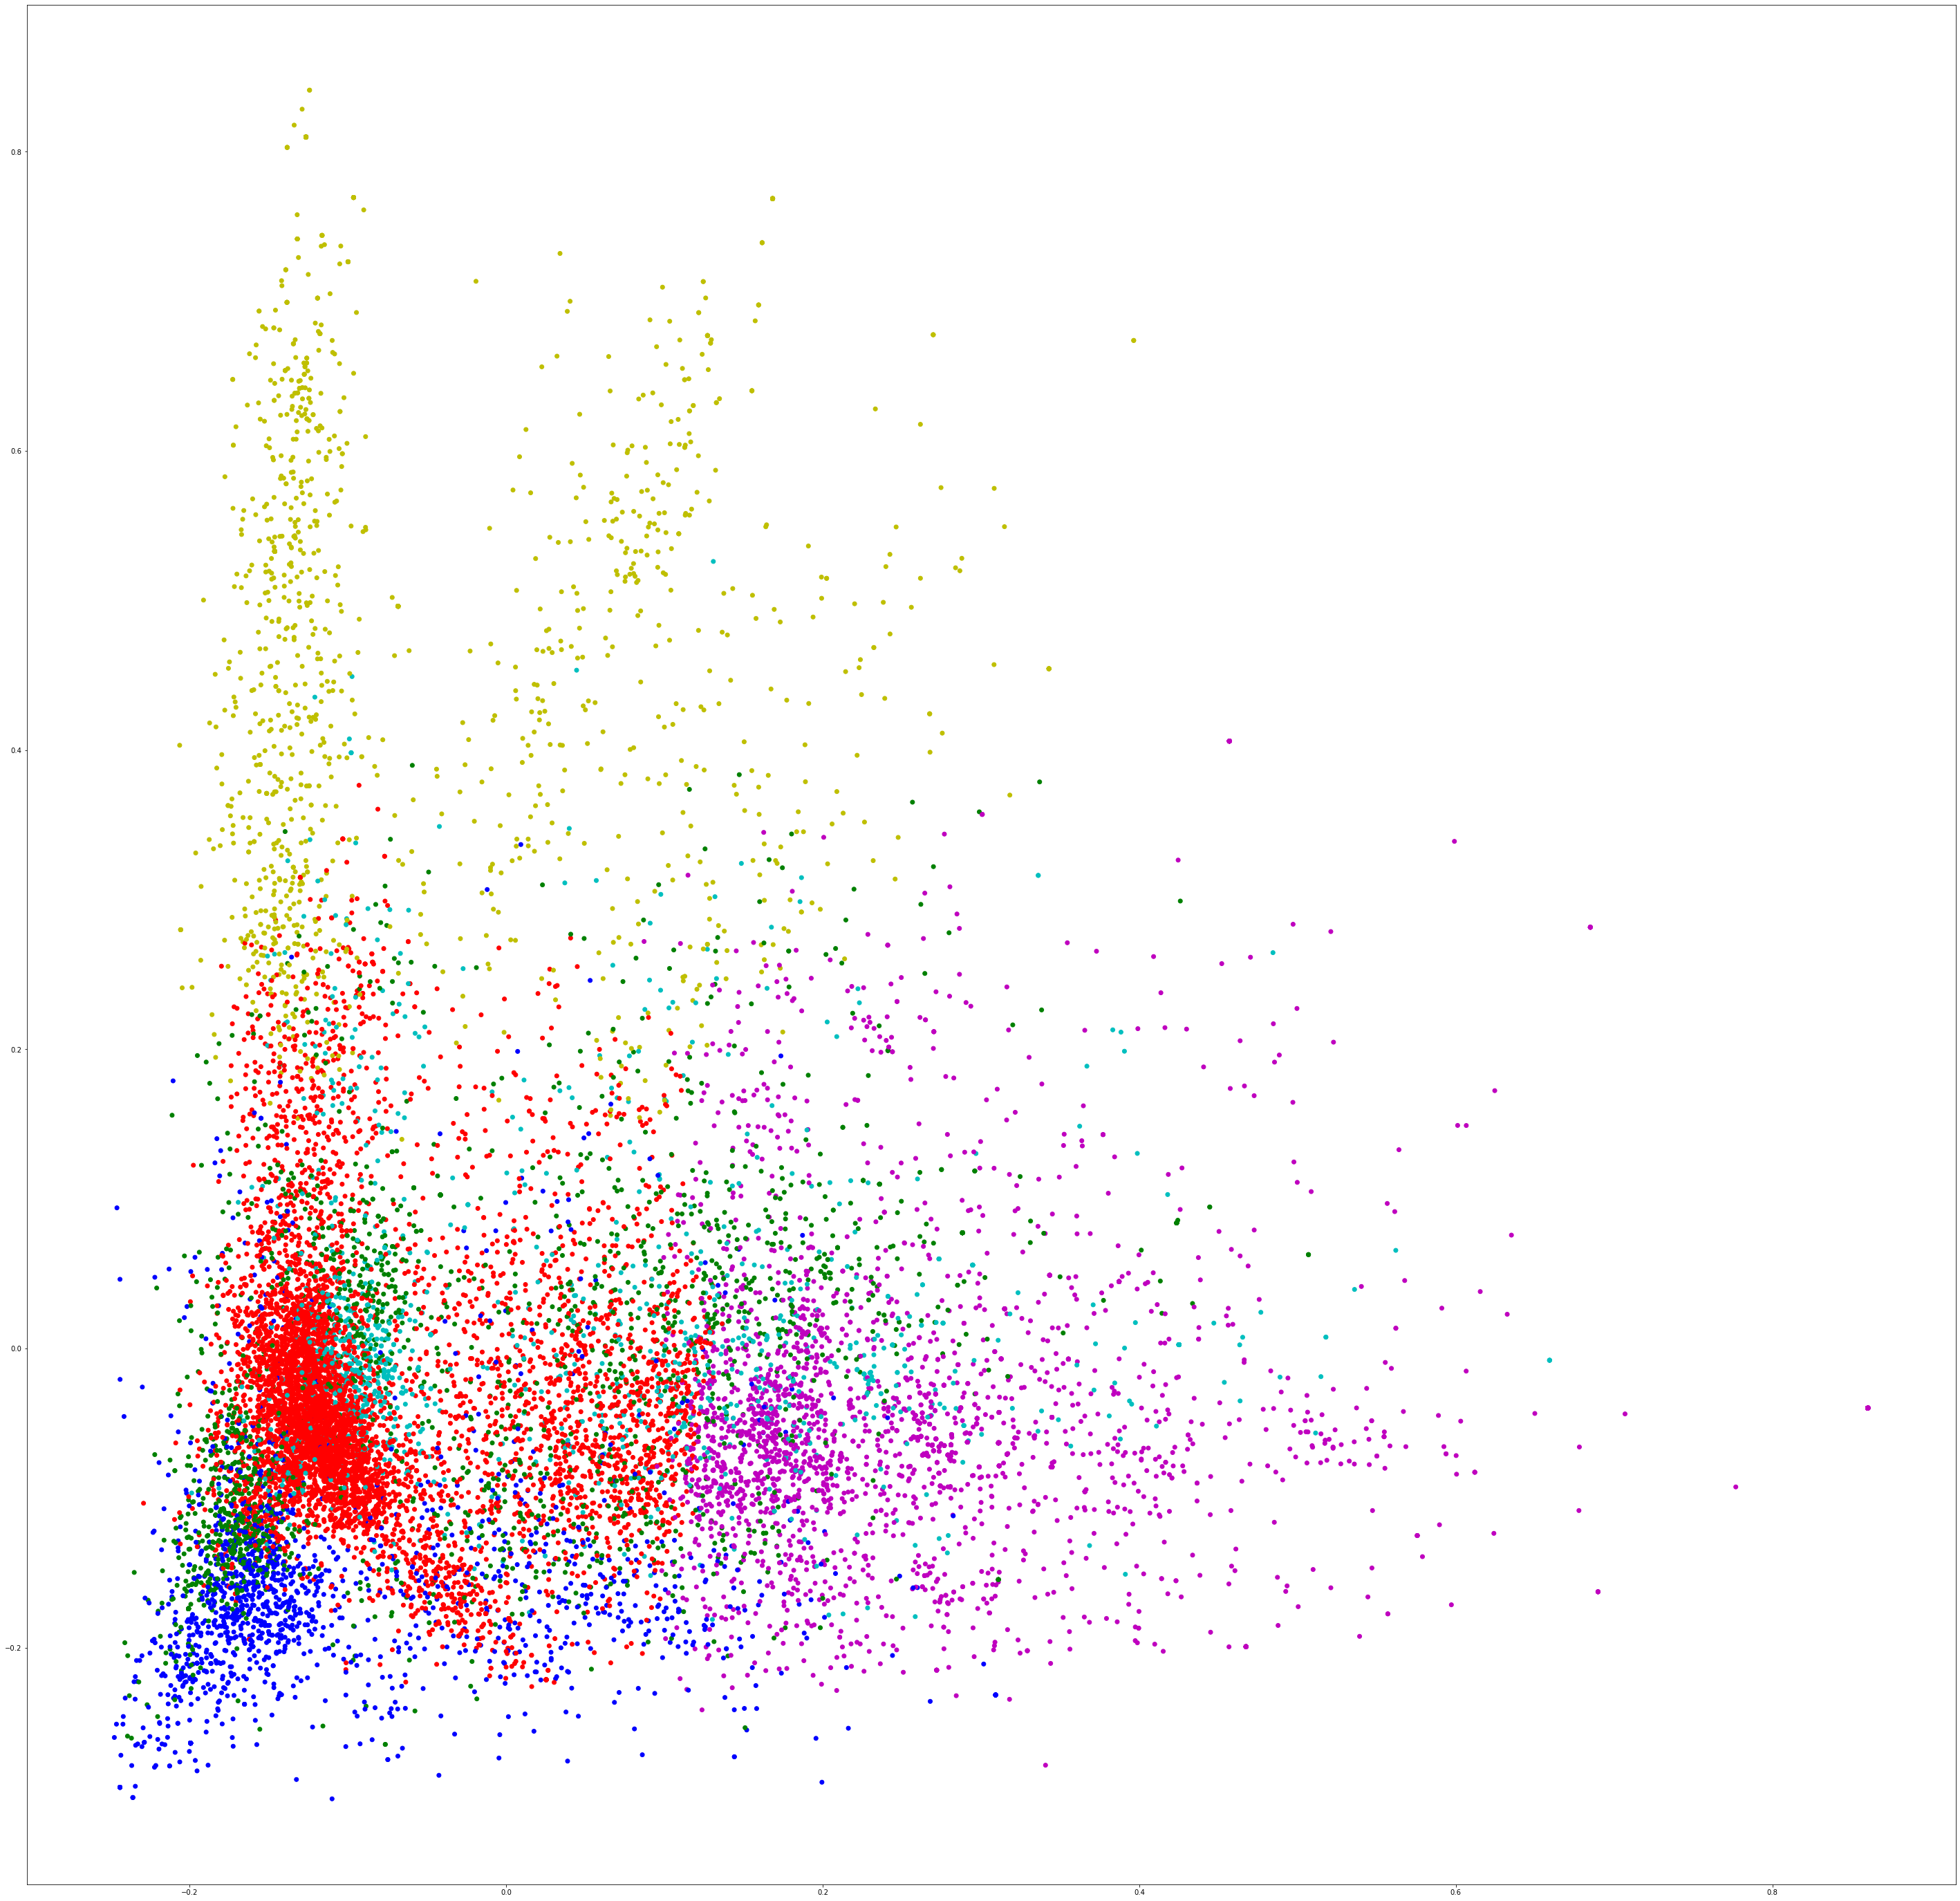

In [31]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])